#### CHAPTER 3
# 분류
### 지도 학습

1. MNIST
2. 이진 분류기 훈련
3. 성능 측정
4. 다중 분류
5. 에러 분석
6. 다중 레이블 분류
7. 다중 출력 분류


고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 MNIST 데이터 셋을 사용하여 여러개의 분류 알고리즘을 작동시킨다.

In [1]:
#세팅
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## MNIST

In [2]:
#사이킷런에서 제공하는 함수를 이용하여 MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
#매개변수: as_frame = True //판다스 데이터프레임 반환 
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 가진 target 키

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28 #이미지는 28x28 픽셀

784

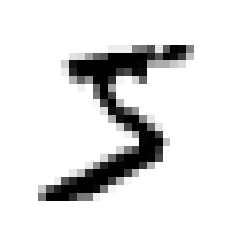

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
#샘플의 특성 벡터를 추출하여 28xx29 배열로 크기를 바꾸고 함수를 이용하여 그리기
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [7]:
#실제 레이블 확인
y[0]

'5'

- 문자열 레이블
- 머신러닝 알고리즘에서의 사용을 위해 y를 정수로 변환

In [8]:
y = y.astype(np.uint8)

In [9]:
#MNIST 이미지 샘플

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [11]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

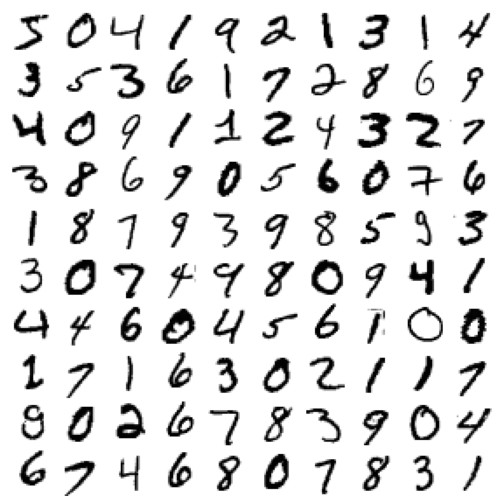

In [12]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

**데이터를 조사하기 전에 항상 테스트 세트를 따로 만들어 떼어놓아야 함**

In [13]:
#훈련세트와 테스트세트
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련

In [14]:
#숫자 5만 식별해보기 #'5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기
y_train_5 = (y_train == 5) #5는 True이고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

In [15]:
#분류 모델을 하나 선택하여 훈련 시키기
#사이킷런의 SGDClassifier를 사용하여 확률적 경사 하강법( SGD) 이용
#SGD는 한 번에 하나씩 훈련 샘플을 독립적으로 처리

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) #SGDClassifier 모델 만들기
sgd_clf.fit(X_train, y_train_5) #전체 훈련세트를 사용하여 훈련

SGDClassifier(random_state=42)

In [16]:
#위에서 만든 모델을 이용하여 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

- 분류기가 이 이미지가 5를 나타낸다고 추측(True)함

## 성능 측정
#### 분류기 평가

In [17]:
#### 교차검증을 사용한 정확도 측정

In [18]:
#사이킷런에서 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 때
#교차 검증 직접 구현 
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [19]:
#fold: 3, 모델: SGDClassifier, 예측 성능 지표: accuracy
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 교차 검증 폴드에 대해 정확도가 95% 이상

In [20]:
#모든 이미지를 '5 아님' 클래스로 분류한느 더미 분류기 만들기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
#모델의 정확도 추측
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 90% 이상의 정확도
- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌
- 특히 불균형한 데이터셋을 다룰 때(즉, 어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그러함

In [22]:
#### 오차 행렬

In [23]:
#클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
#즉, 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶으면, 오차 행렬의 5행 3열을 보면 됨

In [24]:
#오차행렬을 만들기 위해선, 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
from sklearn.model_selection import cross_val_predict

### 테스트 세트로 예픅하면 안됨
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
#cross_val_predict: k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred) #오차행렬 만들기

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- 행은 실제 클래스를 나라태고 열은 예측한 클래스를 나타냄

In [26]:
y_train_perfect_predictions = y_train_5  # 완변한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

- 오차 행렬이 많은 정보를 제공해주지만 가금 더 요약된 지표가 필요할 때가 있음
- 양성 예측의 정확도 살펴보기 -> 정밀도 
- 분류기가 정확하게 감지한 양성 샘플의 비율 -> 재현율or민감도
- 정밀도와 재현율은 함께 사용함

 ![nn](https://mblogthumb-phinf.pstatic.net/MjAxOTA3MjNfNTIg/MDAxNTYzODYzNzI3OTk5.O3L8K5__en1f-CClSXf_NKi-zQbKkj5NVUaVaHT4_8Yg.740uyaCWkYHFpa41tz8PH3YP0340CxTWtyRgQ-a5Sskg.PNG.taewwon/3.PNG?type=w800)

- 정밀도
 ![nn2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbkx8Fh%2FbtqUWtHvygX%2FpkVDXYIB9TtpK1Aq0rFeo0%2Fimg.png)
 
- 재현율
 ![nn3](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbtEm2n%2FbtqUUprWiha%2FDz304PSuf6fpA7z7RnE9Z1%2Fimg.png)

In [27]:
#### 정밀도와 재현율

In [28]:
#정밀도와 재현율을 포함하여 분류기의 지표를 계산
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
#동일한 정밀도를 나타내는 코드
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [31]:
#위 코드의 결과처럼 재현율을 나타내는 코드
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

![nn4](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FedsXg1%2FbtqUUqjZ1x4%2FRu9sW4q0dkaW4ZkLkFWCe0%2Fimg.png)
- F점수: 정밀도와 재현율의 조화 평균

In [32]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred) #F점수를 계산하기 위해 f1_score() 호출

0.7325171197343846

In [33]:
#위 코드의 결과처럼 F점수를 나타내는 코드
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

- 정밀도와 재현율이 비슷한 분류기에서는 F점수가 높음
- 정밀도를 올리면 재현율이 줄고, 정밀도를 줄이면 재현율이 올라감
- 이를 정밀도/재현율 트레이드오프 라고 함

In [34]:
#### 정밀도/재현율 트레이드오프

![nn5](https://blog.kakaocdn.net/dn/cULrDu/btqEYH1R8G2/klkjPvgekm24UtriVsQik0/img.jpg)

- 결정 함수를 사용하여 각 샘플의 점수를 계산
- 이 점수가 임계값보다 크면 샘플을 양성 클래스에 할당
- 그렇지 않으면, 음성 클래스에 할당

<br>
- 사이킷런에서 임계값을 직접 지정할 수는 없음
- 예측에 사용한 점수는 확인할 수 있음

In [35]:
#분류기의 predict() 메서드 대신 decision_function() 이용하여 각 샘플의 점수 확인 
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

- 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들수 있음

In [40]:
threshold = 0 #임계값을 0으로 정함
y_some_digit_pred = (y_scores > threshold)

In [37]:
y_some_digit_pred

array([ True])

- 임계값이 0이므로 위 코드는 predict() 메서드와 같은 결과를 반환

In [41]:
threshold = 8000 #임계값을 8000으로 높임
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임계값을 높이면 재현율은 감소
- 즉, 이미지가 실제로 숫자 5이고 임계값이 0일 때는 분류기가 이를 감지했지만, 임계값이 8000으로 높아지면 이를 놓침

In [ ]:
#### 적절한 임꼐값 정하기

In [42]:
#먼저 cross_val_predict() 함수를 이용하여 훈련세트에 있는 모든 샘플의 점수를 구해야 함
#단, 이번에는 예측 결과가 아니라 결정 점수를 반환 받아야 함
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function") #결정 점수 반환

In [ ]:
#### 이 점수와 precision_recall_curve() 함수를 사용하여 가능한 모든 임계값에 대해 정밀도와 재현율 계산하기

In [43]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

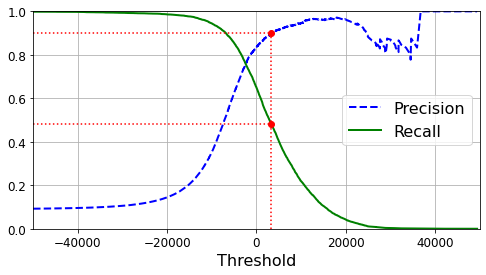

In [44]:
#맷플롯립을 이용하여 임계값의 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) #범례 추가
    plt.xlabel("Threshold", fontsize=16)        #임계값을 표시하고
    plt.grid(True)                             #그리드 추가
    plt.axis([-50000, 50000, 0, 1])            #축 범위 지정



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                               
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                          
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                        
#save_fig("precision_recall_vs_threshold_plot")                                             
plt.show()

- 정밀도 곡선이 재현울 곡선보다 더 울퉁불퉁한 이유: 이는 임계값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문

In [45]:
(y_train_pred == (y_scores > 0)).all()

True

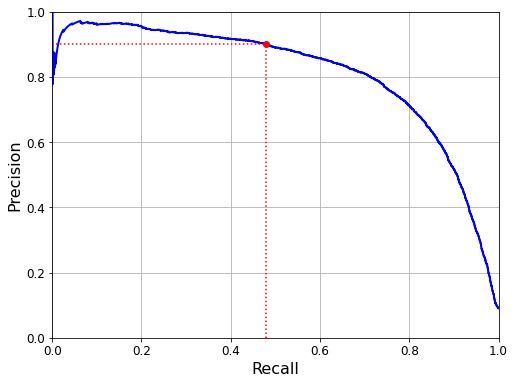

In [46]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

- 재현율에 대한 정밀도 곡선(임계값은 이전 그래프와 동일:0.4799852425751706)
- 재현율 80% 근처에서 정밀도 급격하게 감소
- 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음(ex. 정밀도 60% 지점)

In [48]:
recall_90_precision

0.4799852425751706

In [ ]:
#### 정밀도 90% 달성 목표

In [49]:
#최소한 90% 정밀도가 되는 가장 낮은 임계값 찾을 수 있음
#np.argmax(): 최대값의 첫번째 인덱스를 반환 #여기서는 첫번째 True 값을 의미
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [50]:
threshold_90_precision

3370.0194991439557

In [51]:
#훈련세트에 대한 예측 만들기
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [52]:
#이 예측에 대한 정밀도
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [53]:
#이 예측에 대한 재현율
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

- 정밀도가 90%인 분류기 만들었음
- 정밀도를 높이려면 충분히 큰 임계값을 지정, 단 재현율이 너무 낮다면 높은 정밀도의 분류기는 유용하지 않음

In [ ]:
#### ROC 곡선

- 수신기 조작  특성(ROC) 곡선도 이진 분류에서 널리 사용하는 도구
- ROC 곡선은 거짓양성비율(FPR)에 대한 진짜양성비율(TPR=재현율) 곡선임 *(FPR: 양성으로 잘못 분류된 음성 샘플의 비율)*
- FPR = 1 - TNR(진짜음성비율, 특이도)  
- ROC 그래프는 <민감도(재현율)에 대한 1-특이도> 그래프 라고도 함

In [54]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) #roc_curve() 함수를 사용하여 여러 임곅밧에서 TPR과 FPR을 계산

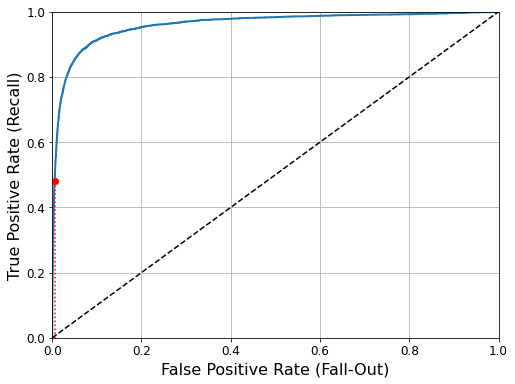

In [56]:
#맷플롯립을 사용해 TPR에 대한 FPR 곡선을 나타낼 수 있음
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
#save_fig("roc_curve_plot")                                   
plt.show()

- 모든 가능한 임계값에서 진짜양성비율에 대한 거짓양성비율을 나타낸 ROC곡선
- 붉은 점은 선택한 비율의 지점(43.68%재현율)
- 재현율이 높을수록 분류기가 만드는 거짓양성이 늘어남
- 점선은 완전한 랜덤 분류기의 ROC 곡선
- 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함(왼쪽 위 모서리)

**곡선아래의 면적(AUC)를 측정하면 분류기들 비교할 수 있음**<br>
**완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5임**

In [57]:
#roc_auc_score(): ROC의 AUC를 계산
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
'''
#TIP
ROC 곡선이 정밀도/재현율(PR) 곡선과 비슷해서 어떤 것을 사용해야할까
양성 클래스가 드물거나 거짓음성보다 거짓양성이 더 중요할 때, 성능 개선 여지가 얼마나 되는지 중심 -> PR곡선
그 외 경우 -> ROC 곡선
'''

In [58]:
#RandomForestClassifier을 훈련시켜 ROC곡선과 ROC AUC 점수 비교

#훈련 세트의 샘플에 대한 점수 얻기
#predict_proba(): 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [59]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest) 
#roc_curve(): 레이블과 점수를 기대. 점수대신 클래스 확률을 전달 할 수 있음

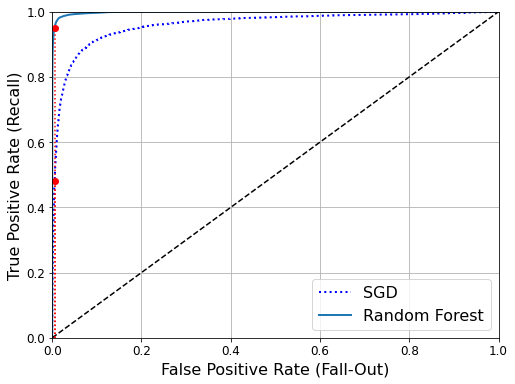

In [61]:
#비교를 위해 첫번째 ROC곡선도 함께 그림
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

- ROC 곡선 비교: 랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋음
- 랜덤 포레스트의 ROC 곡선이 왼쪽 위 모서리에 더 가까워진 AUC 값이 크기 때문

In [62]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

- ROC AUC 점수가 훨씬 높음

In [63]:
#정밀도 점수 계산
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [64]:
#재현율 점수 계산
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## 다중 분류

#### 둘 이상의 클래스 구별

OvR(One-versus-the-rest)전략 orOvA(One-versus-all)
- 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를(0-9까지) 훈련시켜서 클래스가 10개인 숫자 이미지 분류 시스템을 만듦
- 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택

OvV(One-versus-one)전략
- 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것
- 클래스가 N개라면 분류기는 Nx(N-1)/2개가 필요함
- 즉, MNIST 문제에서 45개의 분류기를 훈련시켜야 함
이미지 하나를 분류하려면 45개 분류기 모두를 통과시켜서 가장 많이 양성으로 분류된 크래스를 선택함<br>OvO전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요
<br>
<br>
- 서포트 벡터 머신같은 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호
- 하지만 대부분의 이진분류 알고리즘에서는 OvR을 선호 

In [65]:
#이진분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO 실행
from sklearn.svm import SVC #서포트벡터머신분류기 테스트

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- 5를 구별한 타깃 클래스(y_train_5)대신 0~9까지의 원래 타깃 클래스(y_train)을 사용해 SVC를 훈련시킴
- 사이킷런이 OvO 전략을 사용하여 45개의 이진 분류기를 훈련시킴
- 각각의 결정 점수를 얻어 점수가 갖아 높은 클래스를 선택함

In [66]:
#decision_function(): 샘플당 10개의 점수를 반환
#이 점수는 클래스마다 하나씩
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [67]:
np.argmax(some_digit_scores) #가장 높은 점수의 클래스 

5

In [68]:
svm_clf.classes_  #클래스의 인덱스

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [69]:
svm_clf.classes_[5] #인덱스 5에 해당하는 클래스 5

5

In [70]:
#SVC 기반으로 OvR전략을 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [71]:
len(ovr_clf.estimators_)

10

In [72]:
#훈련시키기
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

- SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없음

In [73]:
#SGD분류기가 클래스마다 부여한 점수 확인
#decision_function(): 클래스마다 하나의 값을 반환
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [74]:
#분류기 평가 -> 교차 검증
#cross_val_score() 함수를 사용해 SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

- 모든 테스트 fold에서 84% 이상을 얻었음
- 성능을 더 높일 여지가 있음
- 간단하게 입력의 스케일을 조정하면 정확도를 89% 이상으로 높일 수 있음

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) #입력의 스케일 조정  *2장 참고
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 에러 분석

- 실제 프로젝트라면 머신러닝 프러젝트 체크리스트의 단계를 따를 것
- 데이터 준비 단계에서 가능한 선택 사항을 탐색하고,
- 여러 모델을 시도하고,
- 가장 좋은 몇 개를 골라
- CridSearchCV를 사용해 하이퍼파라미터를 세밀하게 튜닝하고,
- 가능한 한 자동화 함

가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상 시킬 방법 찾기
- 방법1. 에러의 종류를 분석

In [ ]:
#### 오차 행렬 살펴보기

In [76]:
#cross_val_predict()를 이용하여 예측을 만들고 confusion_matrix() 호출
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [77]:
#오차행렬을 맷플롯립의 matshow() 함수를 사용해 이미지로 표현
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

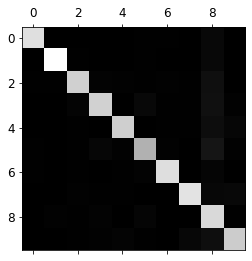

In [78]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

- 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보임
- 숫자 5는 다른 숫자 보다 조금 더 어두워보임
- 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻 *(배열에서 가장 큰 값은 흰색으로, 가장 작은 값은 검은색으로 정규화되어 그려짐)*
<br>
<br>
**그래프의 에러 부분에 초점**
- 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어(에러의 절대 개수가 아님) 에러 비율을 비교함(개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보임)

In [79]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums #각 값을 대응되는 클래스의 이미지 개수로 나눔

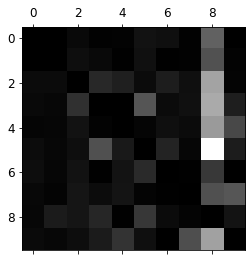

In [81]:
#다른 항목은 그대로 유지하고 주대각선만 0으로 채워 그래프 그림
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

- 분류기가 만든 에러가 확실히 보임
- 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄
- 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시
- 하지만 클래스 8의 행은 나쁘지 않음
- 이는 실제 8이 적절히 8로 분류되었다는 것을 의미
- 오차 행렬은 반드시 대칭인 것은 아님
- 3과 5가 서로 많이 혼동되고 있는 것도 볼 수 있음

**8로 잘못 분류되는 것을 줄이려면?**
- 8처럼 보이는(하지만 실제 8은 아닌) 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있음
- 또는 분류기에 도움 될 만한 특성을 더 찾아볼 수 있음
- Ex. 동심원의 수를 세는 알고리즘( 8은 2개, 6은 1개, 5는 0개)
- 또는 동심원 같은 어떤 패턴이 드러나도록 이미지를 전처리 해볼수 있음

In [ ]:
#### 에러 해결을 위해 3과 5의 샘플을 그려보기

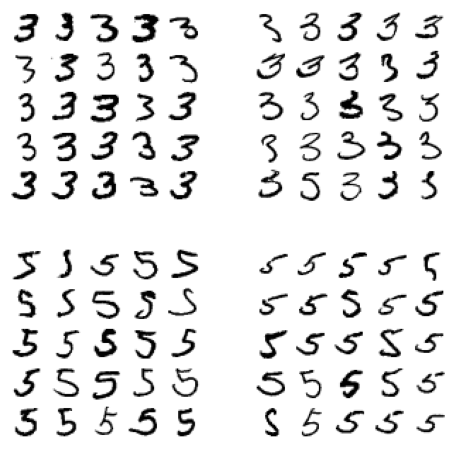

In [83]:
#plot_digits(): 맷플롯립의 imshow() 함수를 사용하는 함수
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

- 왼쪽의 5x5 블록 두 개는 3으로 분류된 이미지이고 오른쪽 5x5 블록 두 개는 5로 분류된 이미지
- 분류기가 잘못 분류한 숫자 중 일부는 정말 잘못 쓰여 있음(왼쪽 아래 블록과 오른쪽 위 블록)
- 분류기가 실수한 이유 -> 선형 모델인 SGDClassifier를 사용했기 때문
- 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함
- 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동 #이미지의 위치, 회전 방향에 민감
- 에러를 줄이는 한가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 하는 것

## 다중 레이블 분류

#### 샘플마다 여러 개의 클래스를 출력
-  여러 개의 이진 꼬리표 출력

In [84]:
#각 숫자 이미지에 두개의 타깃 레이블이 담긴 y_multilabel배열을 만듦
#첫번째 숫자가 큰값(7,8,9)인지 나타내고
#두번째 숫자가 홀수인지 나타냄
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) #큰수체크
y_train_odd = (y_train % 2 == 1) #홀수체크
y_multilabel = np.c_[y_train_large, y_train_odd] 

knn_clf = KNeighborsClassifier() #KNeighborsClassifier 인스턴스 만듦
knn_clf.fit(X_train, y_multilabel) #다중 타깃 배열을 사용하여 훈련

KNeighborsClassifier()

In [85]:
knn_clf.predict([some_digit])

array([[False,  True]])

- 예측 결과 두개의 레이블 출력
- 숫자 5는 크지않고(False), 홀수(True) 임

In [86]:
#각 레이블의 F1 점수를 구하고 간단하게 평균 점수를 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- 이 코드는 모든 레이블의 가중치가 같다고 가정한 것
- 사진이 수가 많은 특정 이미지에 분류기의 점수에 더 높은 가중치를 주려면 레이블에 클래스의 지지도를 가중치로 주면 됨(지지도: 타깃 레이블이 속한 샘플 수)
- 즉, 위의 코드에서 average="weighted" 설정

## 다중 출력 분류

#### 다중 출력 다중 클래스 분류 or 다중 출력 분류
- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것 *(즉, 값을 두개 이상 가질 수 있음)*
<br>
<br>
**이미지의 답음을 제거하는 시스템**
- 잡음이 많은 숫자 이미지를 입력 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
- 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러개 가짐(0-255)
- 픽셀 강도 예측은 분류보다 회귀와 비슷
- 샘플마다 클래스와 값을 모두 포함하는 다중 레이블이 출력되는 시스템도 가능

In [87]:
#MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint() 함수를 사용하여
#픽셀 강도에 잡음을 추가
#타깃 이미지는 원본 이미지가 될 것
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

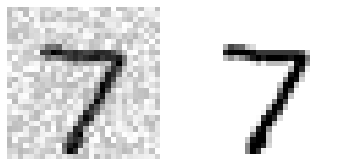

In [88]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

- 왼쪽은 잡음이 섞인 입력 이미지, 오른쪽은 깨끗한 타깃 이미
- 분류기를 훈련시켜 이 이미지를 깨끗하게 만들기

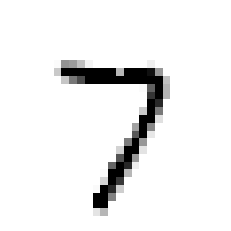

In [89]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
#save_fig("cleaned_digit_example_plot")